In [34]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt, exp, log
import numpy as np
from matplotlib import pyplot as plt
#plt.style.use('seaborn-dark-palette')
plt.style.use('Solarize_Light2')
plt.style.use('seaborn-dark')
from IPython.display import HTML
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.2-BETA7 (19/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.5.2 (19/Jan/2023)


In [35]:
# HTML("""
# <style>
# #notebook-container {background-color: #abc}
# </style>
# """)

In [36]:
plt.rcParams['figure.figsize'] = [8,4]

# Carbon Simulation - Demo 7-1 (Sim Demo)

In [37]:
style_list = ['default', 'classic'] + sorted(
    style for style in plt.style.available
    if style != 'classic' and not style.startswith('_'))
style_list

['default',
 'classic',
 'Solarize_Light2',
 'bmh',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

## Setup

### Define parameters

In [38]:
pair = "ETH/USDC"
vol = 0.5
time = 1
mu = 0
steps = 100
spot0 = 1500

In [39]:
amt_usdc    = 1000            # USDC
amt_eth     = 1               # ETH

w0 = 0.05
w1 = 2*w0

p_buy_a = spot0*(1-w0)
p_buy_b = spot0*(1-w0)*(1-w1)
p_sell_a = spot0*(1+w0)
p_sell_b = spot0*(1+w0)*(1+w1)
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, spot {spot0:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")

buy ETH 1425.0-1282.5, spot 1500.0, sell ETH 1575.0-1732.5


### Calculate derived parameters and set up objects

In [40]:
dt = time/steps
time_r = np.array([i*dt for i in range(steps+1)])
sqrt_dt = sqrt(dt)
mudt = mu*dt
vol_sqrt_dt = vol*sqrt_dt
half_sig2_dt = 0.5*vol*vol*dt
print(sqrt_dt, mudt, vol_sqrt_dt)

0.1 0.0 0.05


In [41]:
Sim = CarbonSimulatorUI(pair="ETH/USDC")
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
Sim.state()["orders"]

,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,1.0,1.0,ETH,False,1575.0,1732.5,1575.0,USDC per ETH,1
1,1,ETHUSDC,USDC,1000.0,1000.0,USDC,False,1425.0,1282.5,1425.0,USDC per ETH,0


### Generate path

buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5


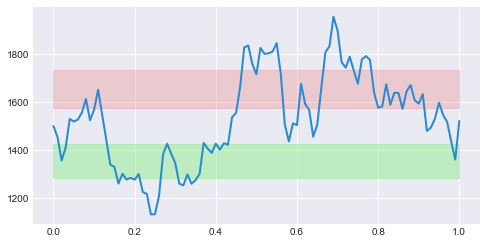

In [45]:
rng = np.random.default_rng()
increments = rng.lognormal(mean=mudt-half_sig2_dt, sigma=vol_sqrt_dt, size=steps)
#multipliers = np.insert(np.cumprod(increments), 0, 1) 
#path = spot0 * multipliers
path = np.cumprod(np.insert(increments, 0, spot0))
plt.plot(time_r, path)
plt.fill_between(time_r, p_buy_a, p_buy_b, color="lightgreen", alpha=0.5)
plt.fill_between(time_r, p_sell_a, p_sell_b, color="lightcoral", alpha=0.3)
plt.grid(visible=True)
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")

## Simulation

In [46]:
Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
print()
print(f"buy ETH {p_buy_a:.1f}-{p_buy_b:.1f}, sell ETH {p_sell_a:.1f}-{p_sell_b:.1f}")
print("-"*20)
printdots = True
#Sim.state()["orders"]
for t, spot, ix in zip(time_r, path, range(len(path))):
    
    orderuis = Sim.state()["orderuis"]
    
    orders_sell_eth = {k:v for k,v in orderuis.items() if v.tkn=="ETH"}
    dy_f_sell_eth = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_eth.values())
    sell_eth  = dy_f_sell_eth(spot)
    
    orders_sell_usdc = {k:v for k,v in orderuis.items() if v.tkn=="USDC"}
    dy_f_sell_usdc = lambda p: sum(o.dyfromp_f(p) for o in orders_sell_usdc.values())
    sell_usdc = dy_f_sell_usdc(spot)
    
    if sell_eth > 0.0001:
        r = Sim.amm_sells("ETH", sell_eth, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_eth:10.2f} ETH {failed}")
        printdots = True
    
    elif sell_usdc > 0.001:
        r = Sim.amm_sells("USDC", sell_usdc, support_partial=True)
        failed = "" if r['success'] else "FAILED"
        print(f"ix={ix:4.0f}, spot={spot:0.1f}: sell {sell_usdc:10.2f} USDC {failed}")
        printdots = True
    
    else:
        if printdots:
            print("...")
        printdots = False
        #print(f"ix={ix:4.0f}, spot={spot:0.1f}: ---")

o = Sim.state()["orders"]
#print(f"ix={ix:4.0f}, spot={spot:0.1f}: -- sim  finished --")
amt_eth_final = abs(float(o.query("tkn=='ETH'")["y"]))
amt_usdc_final = abs(float(o.query("tkn=='USDC'")["y"]))
print("-"*20)
print(f"ix={0:4.0f},  spot={path[0]:0.1f}: {amt_eth:.1f} ETH {amt_usdc:.1f} USDC (={amt_eth*path[0]+amt_usdc:.1f} USDC)")
print(f"ix={ix:4.0f},  spot={spot:0.1f}: {amt_eth_final:.1f} ETH {amt_usdc_final:.1f} USDC (={amt_eth_final*spot+amt_usdc_final:.1f} USDC)")
print()
o


buy ETH 1425.0-1282.5, sell ETH 1575.0-1732.5
--------------------
...
ix=   2, spot=1356.7: sell     472.93 USDC 
...
ix=   8, spot=1612.9: sell       0.34 ETH 
...
ix=  11, spot=1651.3: sell       0.33 ETH 
...
ix=  14, spot=1340.0: sell     950.72 USDC 
ix=  15, spot=1330.4: sell     109.97 USDC 
ix=  16, spot=1261.5: sell     551.29 USDC 
...
ix=  46, spot=1663.8: sell       1.08 ETH 
ix=  47, spot=1826.8: sell       0.78 ETH 
...
ix=  99, spot=1361.2: sell    1356.49 USDC 
...
--------------------
ix=   0,  spot=1500.0: 1.0 ETH 1000.0 USDC (=2500.0 USDC)
ix= 100,  spot=1521.4: 1.0 ETH 1715.7 USDC (=3197.5 USDC)



,id,pair,tkn,y_int,y,y_unit,disabled,p_start,p_end,p_marg,p_unit,lid
0,0,ETHUSDC,ETH,1.859800,0.973991,ETH,False,1575.0,1732.5,1647.213056,USDC per ETH,1
1,1,ETHUSDC,USDC,3072.155385,1715.666499,USDC,False,1425.0,1282.5,1361.154787,USDC per ETH,0
